In [53]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, r2_score

#### Load the Dataset

In [54]:
from google.colab import drive
drive.mount('/content/drive')
# # Replace with the actual path to your file
file_path = '/content/drive/MyDrive/Deep_Dive_Project/uiuc-gpa.pk'
# file_path = '/content/drive/MyDrive/F24/CS547/uiuc-gpa-new.pk'

# file_path = 'uiuc-gpa.pk'

with open(file_path, 'rb') as f:
  df = pickle.load(f)

print(df.shape)
df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(58864, 512)


,Year,Number,Course Title,Avg GPA,A+,A,A-,B+,B,B-,...,"Primary Instructor_Wright, Margaret","Primary Instructor_Wu, Martin G","Primary Instructor_Yang, Xi","Primary Instructor_Yu, Albert","Primary Instructor_Zhang, Jianhua","Primary Instructor_Zhang, Li","Primary Instructor_Zhang, Zheng","Primary Instructor_Zhao, Kai","Primary Instructor_Zhao, Rui","Primary Instructor_Zilles, Craig"
0,2023,100,Intro Asian American Studies,3.530909,0,11,5,1,4,0,...,False,False,False,False,False,False,False,False,False,False
1,2023,100,Intro Asian American Studies,3.797391,0,17,2,1,2,1,...,False,False,False,False,False,False,False,False,False,False
2,2023,100,Intro Asian American Studies,3.476667,0,13,2,2,0,2,...,False,False,False,False,False,False,False,False,False,False
3,2023,200,U.S. Race and Empire,3.606364,6,15,5,2,3,0,...,False,False,False,False,False,False,False,False,False,False
4,2023,215,US Citizenship Comparatively,3.889091,16,12,2,1,1,1,...,False,False,False,False,False,False,False,False,False,False
5,2023,141,ABE Principles: Biological,3.098889,0,5,4,6,5,2,...,False,False,False,False,False,False,False,False,False,False
6,2023,152,Water in Global Environment,3.779427,55,115,0,4,9,0,...,False,False,False,False,False,False,False,False,False,False
7,2023,232,Context Intl Interventions,3.777778,3,13,5,5,1,0,...,False,False,False,False,False,False,False,False,False,False
8,2023,425,Engrg Measurement Systems,3.944167,0,22,0,2,0,0,...,False,False,False,False,False,False,False,False,False,False
9,2023,457,NPS Pollution Processes,3.758182,1,14,4,0,2,0,...,False,False,False,False,False,False,False,False,False,False


In [55]:
column_names = list(df.columns)

In [56]:
course_names = df["Course Title"].unique()
course_names

array(['Intro Asian American Studies', 'U.S. Race and Empire',
       'US Citizenship Comparatively', ...,
       'Intro to Human Physiology Lab', 'Hist Studies in 20thC Music',
       'Ecology of Migratory Birds'], dtype=object)

In [57]:
course_df = df[df["Course Title"]==course_names[0]]
course_df[['Year',	'Number', 'Course Title', 'Term_Spring', 'Term_Summer', 'Term_Winter',]]

,Year,Number,Course Title,Term_Spring,Term_Summer,Term_Winter
0,2023,100,Intro Asian American Studies,True,False,False
1,2023,100,Intro Asian American Studies,True,False,False
2,2023,100,Intro Asian American Studies,True,False,False
2252,2022,100,Intro Asian American Studies,False,False,False
2253,2022,100,Intro Asian American Studies,False,False,False
...,...,...,...,...,...,...
66400,2010,100,Intro Asian American Studies,True,False,False
66401,2010,100,Intro Asian American Studies,True,False,False
66402,2010,100,Intro Asian American Studies,True,False,False
66403,2010,100,Intro Asian American Studies,True,False,False


In [58]:
def preprocess_data(df):
        """
        Preprocess the dataframe:
        - Handle categorical variables
        - Ensure all features are numerical
        - Split data into features (X) and target (y)
        """
        # Shift Year by min(Year)
        min_yr = df['Year'].min()
        df['Year'] -= min_yr

        # Divide Course by 100
        df['Number'] /= 100
        """
        # Remove Avg GPA as y
        X = df.drop(['Avg GPA', 'A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W'], axis=1)
        X = X.to_numpy(np.float32)
        y = df['Avg GPA'].to_numpy(np.float32).reshape(-1, 1)

        print(f"X shape {X.shape}")
        print(f"y shape {y.shape}")
        return X, y
        """
        min_seq_len = 10
        X_train = []
        y_train = []
        X_test = []
        y_test = []
        X, y = [], []
        for course_name in course_names:
            course_df = df[df["Course Title"] == course_name]
            course_feature = course_df.drop(["Course Title", 'Avg GPA', 'A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W'] , axis=1).to_numpy(np.float32)
            """
            test_mask = course_feature[:, 0] == course_feature[:, 0].max()
            train_mask = course_feature[:, 0] < course_feature[:, 0].max()
            course_feature_test = course_feature[test_mask]
            course_feature_train = course_feature[train_mask]

            X_test.append(course_feature_test[:2])
            y_test.append(course_df['Avg GPA'][test_mask].to_numpy(np.float32).reshape(-1, 1)[:2])

            if course_feature_train.shape[0] >= min_seq_len:
                X_train.append(course_feature_train[:min_seq_len])
                y_train.append(course_df['Avg GPA'][:min_seq_len].to_numpy(np.float32).reshape(-1, 1))
            """
            for i in range(0, course_feature.shape[0]-min_seq_len, min_seq_len):
                X.append(course_feature[i:i+min_seq_len])
                y.append(course_df['Avg GPA'][i:i+min_seq_len].to_numpy(np.float32).reshape(-1, 1))


        """
        print(f"Min seq len = {min_seq_len}")

        X_train = np.stack(X_train, axis=0)
        y_train = np.stack(y_train, axis=0)
        X_test = np.vstack(X_test)
        y_test = np.vstack(y_test)
        """
        X = np.stack(X, axis=0)
        y = np.stack(y, axis = 0)
        perm = np.random.permutation(X.shape[0])
        train_size = int(0.8 * perm.shape[0])
        X_train = X[:train_size]
        y_train = y[:train_size]
        X_test = X[train_size:]
        y_test = y[train_size:]

        print(f"X_train shape: {X_train.shape}")
        print(f"y_train shape: {y_train.shape}")
        print(f"X_test shape:  {X_test.shape}")
        print(f"y_test shape:  {y_test.shape}")

        return X_train, y_train, X_test, y_test

In [59]:
# Preprocess the data
X_train, y_train, X_test, y_test = preprocess_data(df)

X_train shape: (3096, 10, 496)
y_train shape: (3096, 10, 1)
X_test shape:  (774, 10, 496)
y_test shape:  (774, 10, 1)


In [60]:
class GPARNN():
    def __init__(self, input_size, hidden_size, num_layers, output_size, lr):
        """
        Initialize the RNN model.
        """
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Check for CUDA availability
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # Define the RNN architecture using nn.RNN
        self.rnn = torch.nn.RNN(
            input_size,
            hidden_size,
            num_layers=num_layers,
            nonlinearity='tanh',
            bias=True,
            batch_first=True,
            dropout=0.2,
            bidirectional=True,
            device=self.device
        )
        self.fc = torch.nn.Linear(hidden_size * 2, output_size, device=self.device)
        self.criterion = torch.nn.MSELoss().to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        # Define the learning rate scheduler
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=200)

    def parameters(self):
        """
        Return model parameters for the optimizer.
        """
        return list(self.rnn.parameters()) + list(self.fc.parameters())

    def forward(self, x):
        """
        Define the forward pass.
        """
        rnn_out, _ = self.rnn(x)  # RNN output and hidden states
        # Take the output of the last time step
        last_output = rnn_out[:, -1, :]
        return self.fc(rnn_out)

    def _convert_to_letter_grade(self, gpas):
        letter_grades = []
        for gpa in gpas:
            if 3.835 < gpa <= 4.0:
                letter_grades.append('A')
            elif 3.50 < gpa <= 3.835:
                letter_grades.append('A-')
            elif 3.165 < gpa <= 3.50:
                letter_grades.append('B+')
            elif 2.835 < gpa <= 3.165:
                letter_grades.append('B')
            elif 2.50 < gpa <= 2.835:
                letter_grades.append('B-')
            elif 2.165 < gpa <= 2.50:
                letter_grades.append('C+')
            elif 1.835 < gpa <= 2.165:
                letter_grades.append('C')
            elif 1.50 < gpa <= 1.835:
                letter_grades.append('C-')
            elif 1.165 < gpa <= 1.50:
                letter_grades.append('D+')
            elif 0.835 < gpa <= 1.165:
                letter_grades.append('D')
            elif 0.5 < gpa <= 0.835:
                letter_grades.append('D-')
            elif 0.0 < gpa <= 0.5:
                letter_grades.append('F')
        return letter_grades

    def train(self, X_train, y_train, X_test, y_test, thres, n_epochs=100, batch_size=32, save_path="best_model.pth"):
        """
        Train the RNN model and save the model with the lowest MSE.
        """
        self.rnn.train()

        X_train = torch.tensor(X_train, dtype=torch.float32).to(self.device)
        y_train = torch.tensor(y_train, dtype=torch.float32).to(self.device)

        train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        X_test = torch.tensor(X_test, dtype=torch.float32).to(self.device)
        y_test = torch.tensor(y_test, dtype=torch.float32).to(self.device)

        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

        best_acc = float("-inf")  # Initialize the best MSE as infinity
        epoch_losses = []
        accs = []
        for epoch in range(n_epochs):
            epoch_loss = 0
            for inputs, labels in train_dataloader:
                self.optimizer.zero_grad()
                outputs = self.forward(inputs)

                loss = self.criterion(outputs, labels)
                loss.backward()
#                 torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
                self.optimizer.step()

                epoch_loss += loss.item()

            # Step the scheduler
            self.scheduler.step()

            # Calculate the average loss for the epoch
            avg_loss = epoch_loss / len(train_dataloader)
            epoch_losses.append(avg_loss)

            # Test the model on the full training data for MSE
            y_preds = []
            y=[]

            self.rnn.eval()

            with torch.no_grad():
                for inputs, labels in test_dataloader:
                    #inputs = inputs.unsqueeze(dim=1)
                    y_pred = self.forward(inputs)[:,-1]
                    y_pred = y_pred.cpu().numpy().squeeze().squeeze()
                    y_preds.append(y_pred)
                    y.append(labels[:,-1].cpu().numpy().squeeze())


                y_preds = np.concatenate(y_preds)
                y = np.concatenate(y)

                mse = mean_squared_error(y_preds, y)
                r2 = r2_score(y, y_preds)

                y = self._convert_to_letter_grade(y)
                y_preds = self._convert_to_letter_grade(y_preds)
                matches = sum(a == b for a, b in zip(y, y_preds))

                # Calculate accuracy
                acc = matches / len(y) * 100
                accs.append(acc)
                print(f"Accuracy:  {acc:.4f}%")
                print(f"MSE:       {mse}")
                print(f"R^2 Score: {r2}")

                # accs = []
                # for t in np.arange(thres[0], thres[1] + 0.01, 0.01):
                #     success = np.abs(y_preds - y) <= t
                #     acc = np.mean(success) * 100
                #     accs.append((t, acc))

                # for t, acc in accs:
                #     print(f"Accuracy (±{t:.2f}):    {acc:.4f}%")

            # Save the model if the MSE improves
            if acc > best_acc:
                best_acc = acc
                torch.save(self.rnn.state_dict(), save_path)
                print(f"[Epoch {epoch + 1}]: New best model saved with ACC {acc:.4f}")

            self.rnn.train()

            if (epoch + 1) % 10 == 0:
                print(f"[Epoch {epoch + 1}/{n_epochs}]: Loss {avg_loss:.4f}, Current Best MSE: {best_acc:.4f}")

        #print(f"Training completed. Best MSE: {best_mse:.4f}")
        return epoch_losses, accs

    def test(self, X, y, thres, model_path="best_model.pth"):
        """
        Test the model and return performance metrics. Load the best model.
        """
        # Load the best model
        self.rnn.load_state_dict(torch.load(model_path))
        self.rnn.eval()

        X_test = torch.tensor(X, dtype=torch.float32).to(self.device)
        y_test = torch.tensor(y, dtype=torch.float32).to(self.device)

        test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

        y_preds = []
        y=[]

        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs = inputs.unsqueeze(dim=1)
                y_pred = self.forward(inputs).cpu().numpy()
                y_pred = y_pred.squeeze().squeeze()
                y_preds.append(y_pred[:,-1])
                y.append(labels[:,-1].cpu().numpy().squeeze())

            y_preds = np.hstack(y_preds)
            y = np.hstack(y)
            mse = mean_squared_error(y_preds, y)

            # accs = []
            # for t in np.arange(thres[0], thres[1] + 0.01, 0.01):
            #     success = np.abs(y_preds - y) <= t
            #     acc = np.mean(success) * 100
            #     accs.append((t, acc))

            mse = mean_squared_error(y, y_preds)
            r2 = r2_score(y, y_preds)

            # for t, acc in accs:
            #     print(f"Accuracy (±{t:.2f}):    {acc:.4f}%")
            print(f"Mean Squared Error : {mse}")
            print(f"R-squared Score :    {r2}")

        return accs, mse, r2

    def predict(self, X, model_path="best_model.pth"):
        """
        Make predictions with the trained model. Load the best model.
        """
        # Load the best model
        self.rnn.load_state_dict(torch.load(model_path))
        self.rnn.eval()

        X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            X_tensor = X_tensor.unsqueeze(1)  # Add sequence dimension
            y_pred = self.forward(X_tensor)
        return y_pred.cpu().numpy()


In [61]:
# Initialize the RNN
input_size = 496  # Number of features
hidden_size = 64
num_layers = 4
output_size = 1

# Initialize the model
rnn = GPARNN(input_size, hidden_size, num_layers, output_size, lr=5e-3)

# Train the model
losses, accs = rnn.train(X_train, y_train, X_test, y_test, n_epochs=100, batch_size=128, thres=[0.01, 0.1])

# # Test the model
#accs, mse, r2 = rnn.test(X_test, y_test, thres=[0.01, 0.1])

Accuracy:  31.1370%
MSE:       0.16338810324668884
R^2 Score: -0.07330989837646484
[Epoch 1]: New best model saved with ACC 31.1370
Accuracy:  31.1370%
MSE:       0.15177768468856812
R^2 Score: 0.002959907054901123
Accuracy:  31.1370%
MSE:       0.15178902447223663
R^2 Score: 0.0028853416442871094
Accuracy:  31.1370%
MSE:       0.15899817645549774
R^2 Score: -0.0444720983505249
Accuracy:  31.1370%
MSE:       0.15329991281032562
R^2 Score: -0.007039666175842285
Accuracy:  30.4910%
MSE:       0.15992404520511627
R^2 Score: -0.05055427551269531
Accuracy:  31.2661%
MSE:       0.12993840873241425
R^2 Score: 0.14642393589019775
[Epoch 7]: New best model saved with ACC 31.2661
Accuracy:  36.1757%
MSE:       0.12390237301588058
R^2 Score: 0.1860750913619995
[Epoch 8]: New best model saved with ACC 36.1757
Accuracy:  37.0801%
MSE:       0.11436119675636292
R^2 Score: 0.24875187873840332
[Epoch 9]: New best model saved with ACC 37.0801
Accuracy:  33.2041%
MSE:       0.13298431038856506
R^2 Score

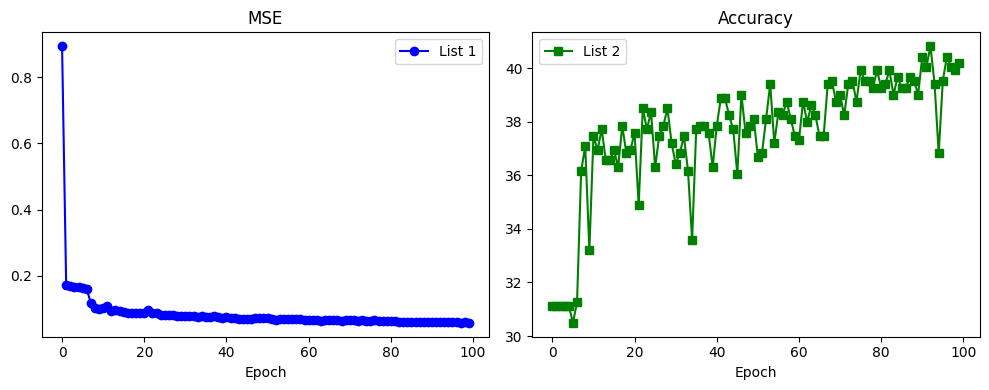

In [63]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Plot the first list on the first subplot
ax[0].plot(losses, marker='o', color='b', label='List 1')
ax[0].set_title('MSE')
ax[0].set_xlabel('Epoch')
# ax[0].set_ylabel('Values')
ax[0].legend()

# Plot the second list on the second subplot
ax[1].plot(accs, marker='s', color='g', label='List 2')
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epoch')
# ax[1].set_ylabel('Values')
ax[1].legend()

# Adjust layout
plt.tight_layout()

# Display the plots
plt.show()